# Project 1: Resolving the sources of gas ionisation in galaxies using optical spectroscopy. #


### Import Recquired Packages ###

In [160]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel

### Read in fits files ###

In [35]:
blue = fits.open('ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz')
red = fits.open('ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz')

In [36]:
blue.info()
red.info()

Filename: ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   float64   
Filename: ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   float64   


In [43]:
blue[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   50                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                 2048                                                  
EXTEND  =                    T                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 25.5 / Pixel coordinate of reference point            
CRPIX2  =                 25.5 / Pixel coordinate of reference point            
CRPIX3  =               1024.0 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.000138888888888

### Generate a wavelength vector from the header information ###

In [15]:
def SAMI_WAVE(header):
    CDELT=header['CDELT3']
    CRVAL=header['CRVAL3']
    CRPIX=header['CRPIX3']
    npix=header['NAXIS3']
    x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
    return x

In [47]:
SAMI_WAVE(blue[0].header)

array([3650.        , 3651.05031754, 3652.10063508, ..., 5797.89936492,
       5798.94968246, 5800.        ])

### Plot Flux vs Wavelength ###

In [62]:
#make a tag to call specific PRIMARY flux 
bluespec=blue[0].data
redspec=red[0].data

In [63]:
# Check length is 2048
bluespec[:,24,24].shape

(2048,)

Text(0, 0.5, 'Flux(/1e-16 erg/cm$^2$/s/Angstrom')

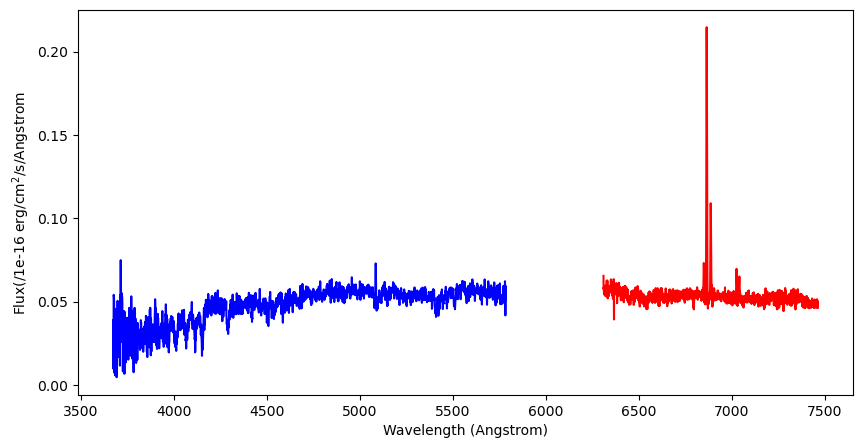

In [71]:
#plot both the blue and red spectra on the same graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
#plot labels
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')

In [79]:
## GET plt.imshow() to work here

### Correcting spectra for foreground extinction due to dust ###

In [133]:
#DUST_CORR is a function that corrects the individual blue or red spectra for a single pixel
def DUST_CORR(colour, pixel):
    test = pixel*(colour[4].data)
    return test
    

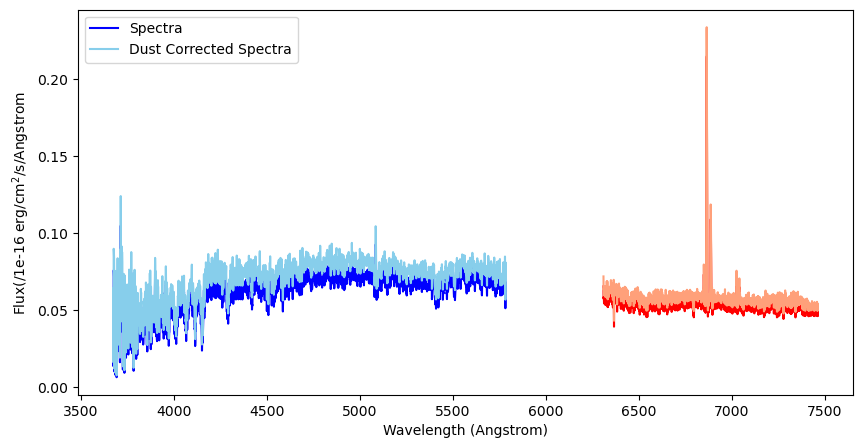

In [136]:
#Here we plot the original test pixel spectra against the newly dust corrected spectra for the same pixel. 
#Lighter colours show the dust corrected spectra.
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue', label='Spectra')
plt.plot(SAMI_WAVE(blue[0].header), DUST_CORR(blue,bluespec[:,24,24]), 'skyblue', label='Dust Corrected Spectra')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
plt.plot(SAMI_WAVE(red[0].header), DUST_CORR(red,redspec[:,24,24]), 'lightsalmon')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

### Find the quadrature difference between blue and red arm instrumental resolutions ###

 $\sqrt{FWHM_{blue}^2 - FWHM_{red}^2}$

In [150]:
#Blue-arm FWHM is 2.66 Angstrom
#Red-arm FWHM is 1.59 Angstrom
dFWHM=np.sqrt((2.66**2)-(1.59**2))
dFWHM

2.1324868112136124

### Convolve red arm flux and variance ###

In [182]:
#first we define the standard deviation so we can feed it into our kernel 
sd=dFWHM/2.355
sdpix=sd/red[0].header['CDELT3']
print(sd, sdpix)

0.9055145695174575 1.519334691641124


In [199]:
#define our gaussian kernel 
gauss = Gaussian1DKernel(sdpix)
gauss.array


array([1.07837940e-04, 1.16824163e-03, 8.20645123e-03, 3.73800369e-02,
       1.10404221e-01, 2.11442970e-01, 2.62580482e-01, 2.11442970e-01,
       1.10404221e-01, 3.73800369e-02, 8.20645123e-03, 1.16824163e-03,
       1.07837940e-04])

In [201]:
convspec= convolve(redspec[:,24,24], gauss.array)

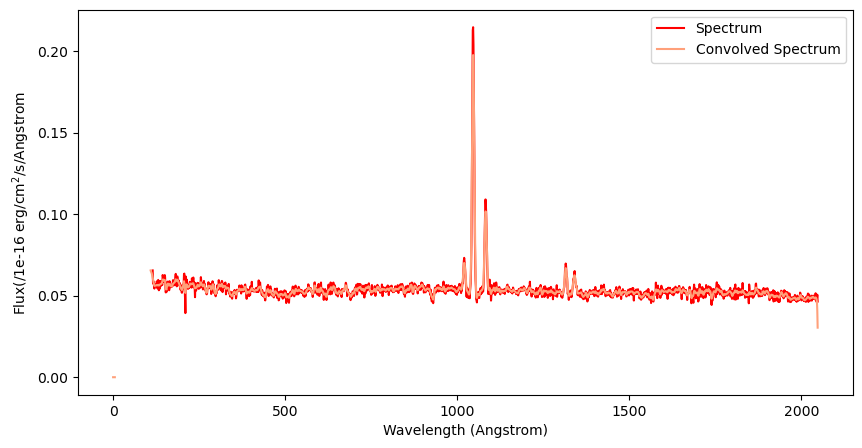

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(redspec[:,24,24], 'red', label='Spectrum')
plt.plot(convspec, 'lightsalmon', label='Convolved Spectrum')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

### Create a wavelength vector of blue arm pixel size ###

SAMI_WAVE above can be used for the blue arm but this needs to be adapted for the red to give blue pixel size over these wavelengths.

In [213]:

print(SAMI_WAVE(blue[0].header), SAMI_WAVE(red[0].header))

[3650.         3651.05031754 3652.10063508 ... 5797.89936492 5798.94968246
 5800.        ] [6240.         6240.59599414 6241.19198828 ... 7458.80801172 7459.40400586
 7460.        ]


In [218]:
def SAMI_BLUE_WAVE(header, header2):
    CDELT=header['CDELT3']
    CRVAL=header['CRVAL3']
    CRPIX=header['CRPIX3']
    npix=header['NAXIS3']
    x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
    CRVAL2=header2['CRVAL3']
    CRPIX2=header2['CRPIX3']
    npix2=header2['NAXIS3']
    x2=CRVAL2+CDELT*(np.arange(npix2)+1-CRPIX2)
    return x, x2

In [219]:
SAMI_BLUE_WAVE(blue[0].header, red[0].header)

(array([3650.        , 3651.05031754, 3652.10063508, ..., 5797.89936492,
        5798.94968246, 5800.        ]),
 array([5775.2271617 , 5776.27747924, 5777.32779678, ..., 7923.12652662,
        7924.17684416, 7925.2271617 ]))